In [1]:
import numpy as np
from scipy.sparse import identity, kron, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import eigh
from functools import reduce
import matplotlib.pyplot as plt


In [2]:
id2 = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    return reduce(kron, operators)

def build_operator(op, site, L):
    ops = [id2] * L
    ops[site] = op
    return kronecker(ops)

def all_site_operators(op, L):
    return [build_operator(op, i, L) for i in range(L)]


In [3]:
def transverse_field_ising_hamiltonian(h, J, eps, L, sparse=True):
    dtype = np.complex128
    H = csr_matrix((2**L, 2**L), dtype=dtype)
    sx_list = all_site_operators(sigma_x, L)
    sz_list = all_site_operators(sigma_z, L)

    for i in range(L - 1):
        H += -J * (sz_list[i] @ sz_list[i+1])
    for sx in sx_list:
        H += -h * sx
    for sz in sz_list:
        H += -eps * sz

    return H if sparse else H.toarray()


In [4]:
def symmetric_initial_state(L):
    up = np.zeros(2**L); up[0] = 1  # all up
    down = np.zeros(2**L); down[-1] = 1  # all down
    psi = (up + down).astype(np.complex128)
    return psi / np.linalg.norm(psi)


In [5]:
def compute_ground_overlap(psi, H_dense):
    eigvals, eigvecs = eigh(H_dense)
    delta = np.abs(eigvals[1] - eigvals[0])

    if delta < 1e-10:
        v1, v2 = eigvecs[:, 0], eigvecs[:, 1]
        proj = np.abs(np.vdot(v1, psi))**2 + np.abs(np.vdot(v2, psi))**2
        print(f"Warning: Ground state degeneracy detected. Delta = {delta:.2e}")
    else:
        v1 = eigvecs[:, 0]
        proj = np.abs(np.vdot(v1, psi))**2
    return proj


In [57]:
# Parameters
L = 4
T = 100.0
h_f = 2.0
eps = 0.0  # set to e.g. 1e-3 to break symmetry
timesteps = 1000
times = np.linspace(0, T, timesteps)
dt = times[1] - times[0]

# Initial state and evolution
psi = symmetric_initial_state(L)

energy_gaps_ed = []
ground_state_energies = []
overlaps = []

for t in times[:]:
    s = t / T
    h = s * h_f
    J = 1.0
    H_sparse = transverse_field_ising_hamiltonian(h=h, J=J, eps=eps, L=L, sparse=True)
    H_dense = H_sparse.toarray()

    eigenvals_ed, _ = eigh(H_dense)
    energy_gaps_ed.append(eigenvals_ed[1] - eigenvals_ed[0])

    ground_state_energy_adiabatic = np.real(psi.conjugate() @ H_dense @ psi)
    ground_state_energy_ed = eigenvals_ed[0]
    ground_state_energies.append([ground_state_energy_adiabatic, ground_state_energy_ed])

    overlaps.append(compute_ground_overlap(psi, H_dense))
    psi = expm_multiply(-1j * H_sparse * dt, psi)
    psi /= np.linalg.norm(psi)

ground_state_energies = np.array(ground_state_energies)

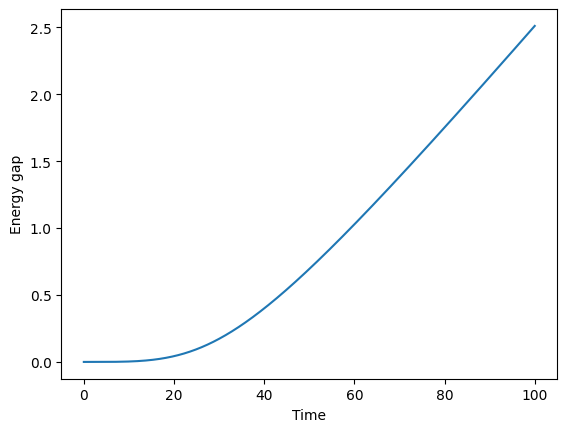

In [58]:
plt.plot(times, energy_gaps_ed, label='Energy gap')
plt.xlabel('Time')
plt.ylabel('Energy gap');

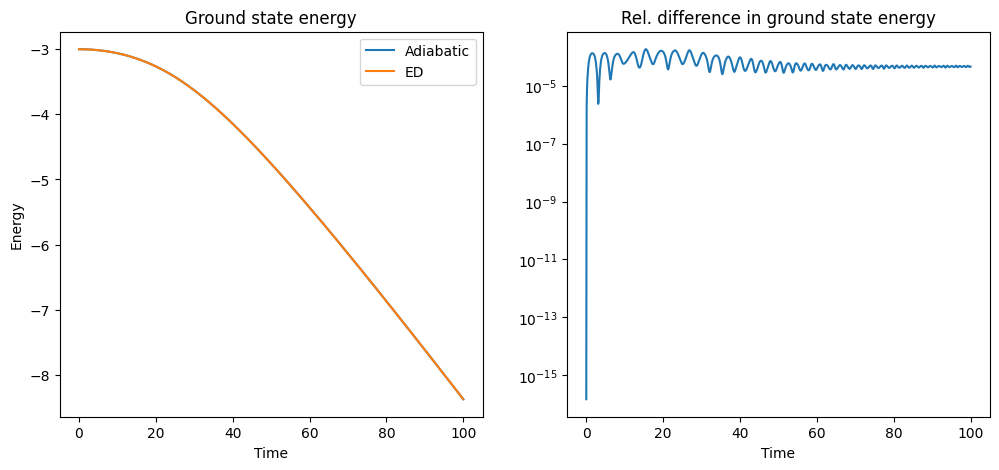

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

ax[0].plot(times, ground_state_energies[:, 0], label='Adiabatic')
ax[0].plot(times, ground_state_energies[:, 1], label='ED')
ax[0].set_ylabel('Energy')
ax[0].set_xlabel('Time')

ax[0].set_title('Ground state energy')
ax[0].legend()

ground_state_diff = (ground_state_energies[:, 0] - ground_state_energies[:, 1]) / np.abs(ground_state_energies[:, 1])
ax[1].plot(times, ground_state_diff, label='Difference in ground state energy')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time')
ax[1].set_title('Rel. difference in ground state energy');

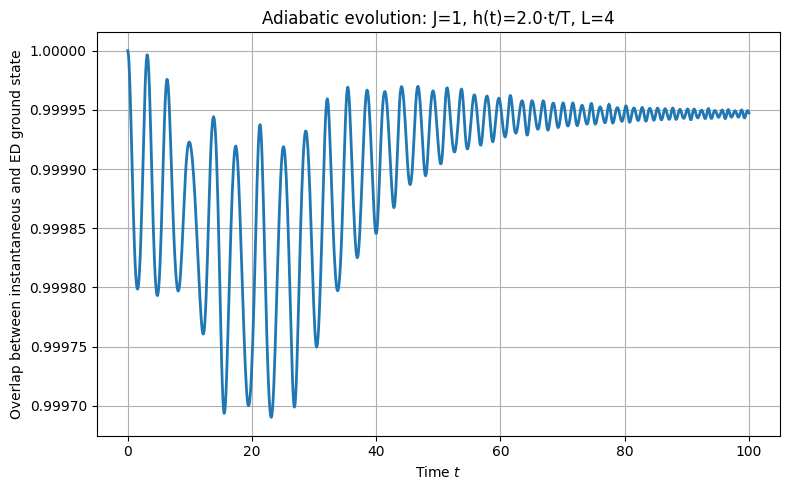

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(times, overlaps, lw=2)
plt.xlabel("Time $t$")
plt.ylabel("Overlap between instantaneous and ED ground state")
plt.title(f"Adiabatic evolution: J=1, h(t)={h_f}·t/T, L={L}")
plt.grid(True)
plt.tight_layout()
plt.show()
